# Diamond Price Prediction

**Мета роботи** - передбачення ціни діамантів на основі їх характеристик.

Набір даних містить `53940` спостережень і `10` змінних. Змінні мають наступний вигляд:

|Column Name|Description|
|-----------|-----------|
|carat|Weight of the diamond|
|cut|Quality of the cut (Fair, Good, Very Good, Premium, Ideal)|
|color|Diamond colour, from J (worst) to D (best)|
|clarity|How clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))|
|x|Length in mm|
|y|Width in mm|
|z|Depth in mm|
|depth|Total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)|
|table|Width of top of diamond relative to widest point (43--95)|
|price|Price in US dollars (326--18,823)|

Перегляд перших рядків даних:
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75

Описова статистика:
              carat         depth         table         price             x  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean       0.799444     61.753006     57.457830   3944.805440      5.734403   
std        0.475173      1.431088      2.232092   3997.938105      1.123077   
min        0.200000     43.000000     43.000000    326.000000      0.000000   
25%        0.400000     61.000000     56.000000    951.000000      4.710000   
50%        0.700000     61.800000     57.000000  

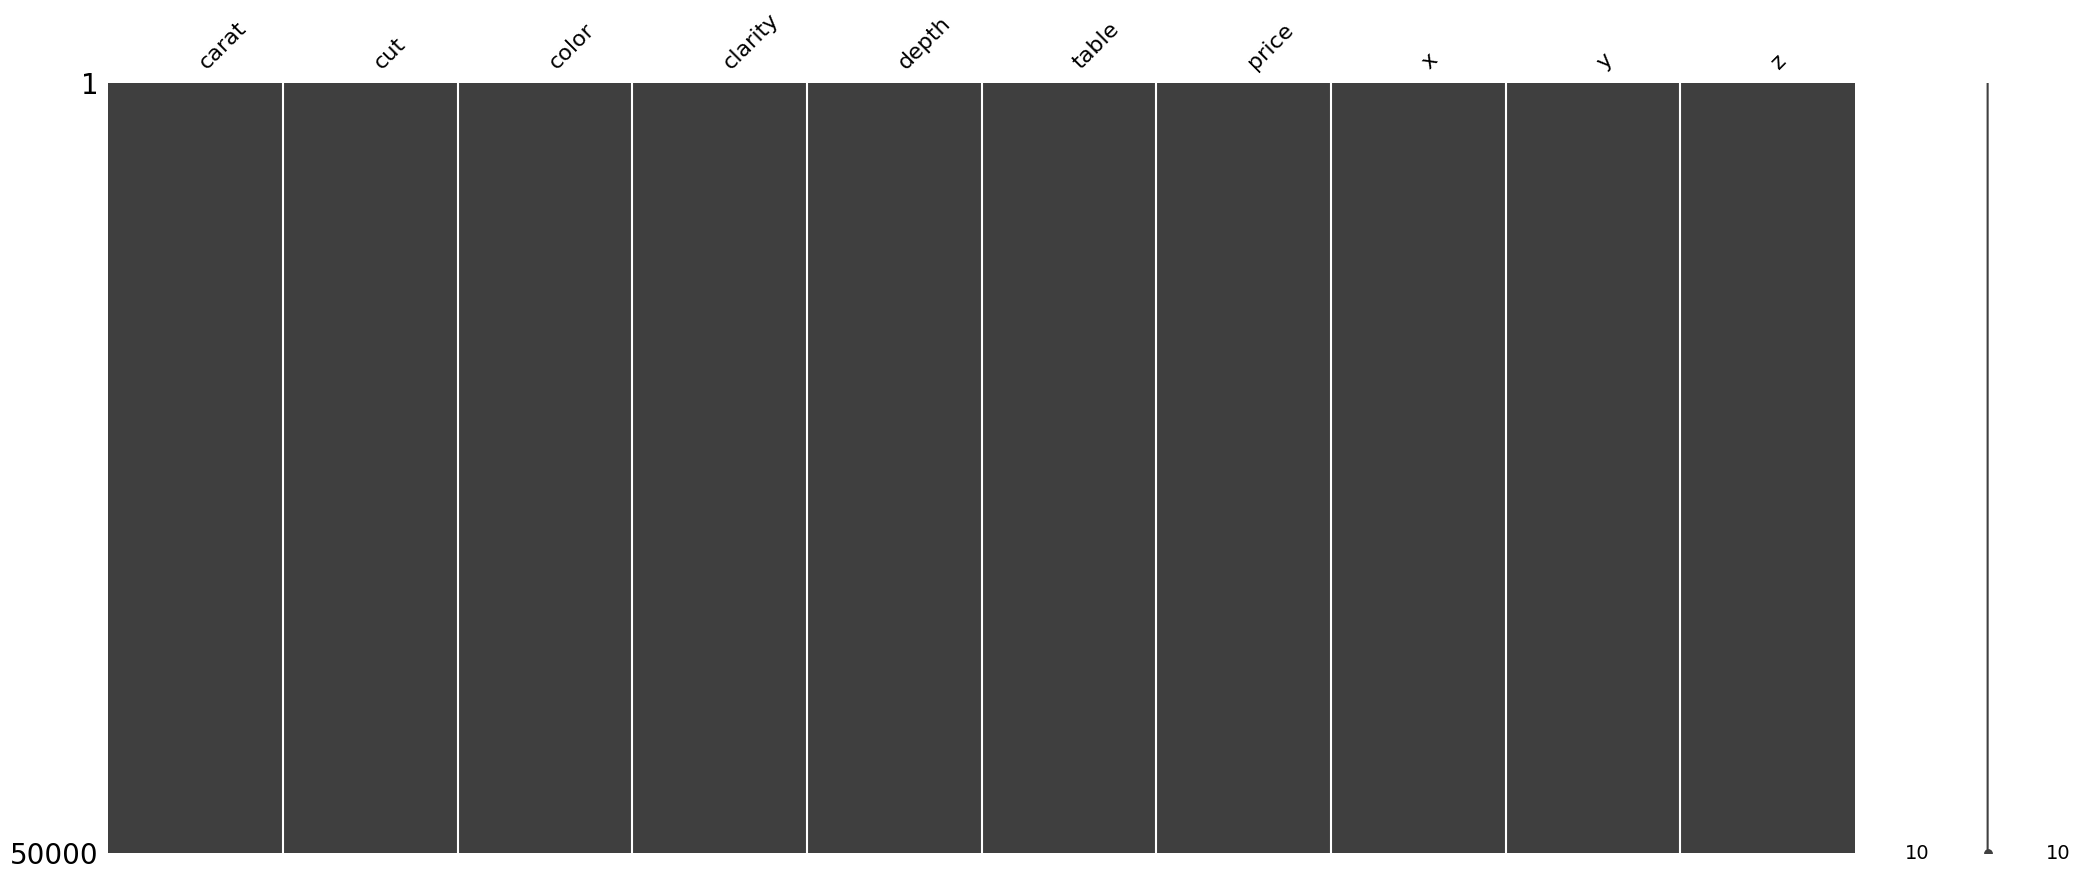

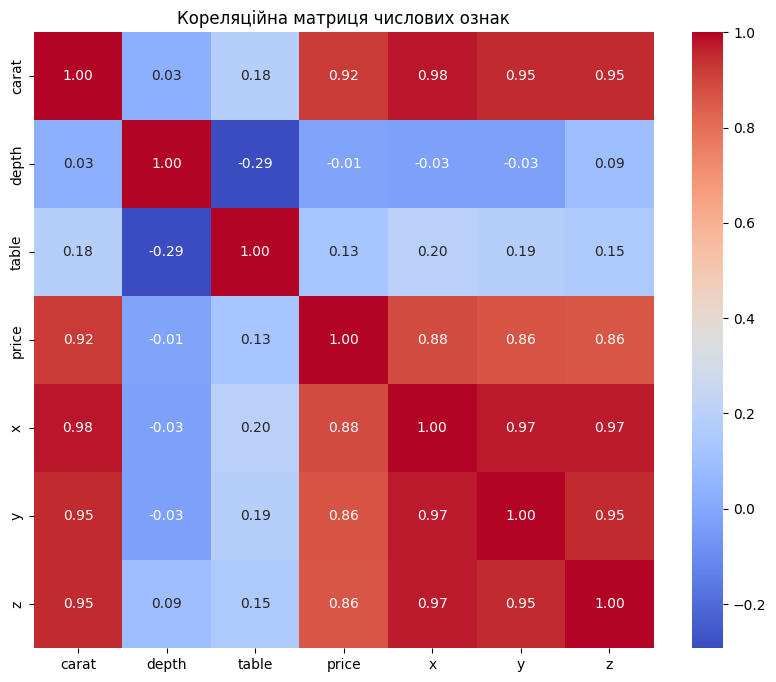


Decision Tree Regressor:
  - Mean Squared Error: 532712.05
  - R2 Score: 0.97

Random Forest Regressor:
  - Mean Squared Error: 289958.53
  - R2 Score: 0.98

XGB Regressor:
  - Mean Squared Error: 291958.45
  - R2 Score: 0.98
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 3958.315100

LightGBM Regressor:
  - Mean Squared Error: 279593.58
  - R2 Score: 0.98

Найкраща модель Random Forest після налаштування:
  - Mean Squared Error: 286196.63
  - R2 Score: 0.98

Найкраща модель XGB після налаштування:
  - Mean Squared Error: 273010.76
  - R2 Score: 0.98


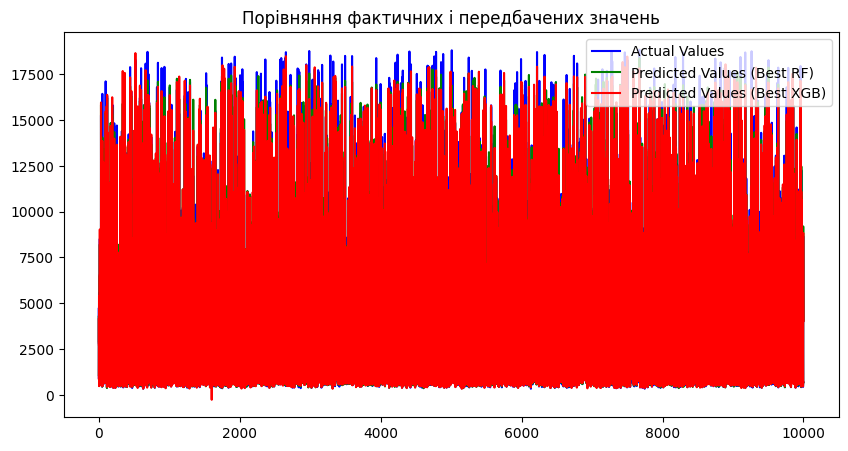

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Ігнорувати попередження для чистоти виводу
import warnings
warnings.filterwarnings("ignore")

# Завантаження даних
data = pd.read_csv('diamonds.csv')
print("Перегляд перших рядків даних:")
print(data.head())

# Опис статистики
print("\nОписова статистика:")
print(data.describe())

# Перевірка на пропущені значення
print("\nКількість пропущених значень:")
print(data.isnull().sum())

# Візуалізація пропущених даних
msno.matrix(data)
plt.show()

# Візуалізація кореляції тільки для числових ознак
numeric_data = data.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Кореляційна матриця числових ознак')
plt.show()

# Розділення даних на ознаки (X) і цільову змінну (y)
X = data.drop(columns='price')
y = data['price']

# Обробка категоричних змінних та масштабування числових ознак
numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical_features = ['cut', 'color', 'clarity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Створення та навчання моделей
models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGB Regressor": XGBRegressor(objective='reg:squarederror', eval_metric='rmse'),
    "LightGBM Regressor": lgb.LGBMRegressor()
}

# Поділ на навчальну та тестову множини
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Навчання моделей і оцінка результатів
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name}:")
    print(f"  - Mean Squared Error: {mse:.2f}")
    print(f"  - R2 Score: {r2:.2f}")

# Налаштування гіперпараметрів для Random Forest
param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestRegressor())])
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
#Roman Davydiuk
# Налаштування гіперпараметрів для XGB
param_grid_xgb = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2]
}
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('model', XGBRegressor(objective='reg:squarederror'))])
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=3, scoring='r2', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Оцінка оптимізованих моделей
print("\nНайкраща модель Random Forest після налаштування:")
print(f"  - Mean Squared Error: {mean_squared_error(y_test, y_pred_best_rf):.2f}")
print(f"  - R2 Score: {r2_score(y_test, y_pred_best_rf):.2f}")

print("\nНайкраща модель XGB після налаштування:")
print(f"  - Mean Squared Error: {mean_squared_error(y_test, y_pred_best_xgb):.2f}")
print(f"  - R2 Score: {r2_score(y_test, y_pred_best_xgb):.2f}")

# Візуалізація результатів найкращих моделей
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Values', color='blue')
plt.plot(y_pred_best_rf, label='Predicted Values (Best RF)', color='green')
plt.plot(y_pred_best_xgb, label='Predicted Values (Best XGB)', color='red')
plt.legend()
plt.title('Порівняння фактичних і передбачених значень')
plt.show()


# Завдання:
- Завантажити вибірку `diabetes.csv`;
- Провести попередній аналіз даних;
- Розділити дані на навчальну та тестову множини;
- Підібрати моделі та навчити обрані моделі;
- Налаштувати гіперпараметри;
- Провести аналіз результатів:
  - метрики оцінки якості;
  - побудувати звіти.
- Зробити висновки та обрати найкращу модель.

## Важливо!!!

Кожна Ваша дія має підкріплюватись висновками, без чітко сформульованих висновків робота не буде зарахована. Всі графікі, всі результати навчання моделей мають підкріплюватись Вашими висновками та аналітикою того, що наведено на графіках. Результати метрик якості мають завершуватись інтерпретацією значень по метрикам, які Ви отримали.

**Необхідно натренувати мінімум 2 моделі для прогнозування!!!**